### BLEU

In [24]:
import nltk
hypothesis = ['It', 'is', 'a', 'cat', 'at', 'room']
reference = ['It', 'is', 'a', 'cat', 'inside', 'the', 'room']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

def BLEUsent(hypothesis, references):
    ref = [x.split(' ') for x in references]
    hyp = hypothesis.split(' ')
    BLEUscore = nltk.translate.bleu_score.sentence_bleu(ref, hyp)
    return BLEUscore

0.4548019047027907


In [17]:
# I should use this library because it's standardized and does tokenization
# more accurately
import sacrebleu

### SARI

In [15]:
from utils.sari import *
fnamenorm   = "./turkcorpus/test.8turkers.tok.norm"
fnamesimp   = "./turkcorpus/test.8turkers.tok.simp"
fnameturk  = "./turkcorpus/test.8turkers.tok.turk."

ssent = "About 95 species are currently accepted ."
csent1 = "About 95 you now get in ."
csent2 = "About 95 species are now agreed ."
csent3 = "About 95 species are currently agreed ."
rsents = ["About 95 species are currently known .", "About 95 species are now accepted .", "95 species are now accepted ."]

print(SARIsent(ssent, csent1, rsents))
print(SARIsent(ssent, csent2, rsents))
print(SARIsent(ssent, csent3, rsents))

0.2682782411698074
0.5889995423074248
0.5071608864657479


###  BERTScore

In [51]:
import bert_score as bs

def BERTSCOREsent(hypothesis, references):
    hypothesis_all = [hypothesis for _ in range(len(references))]
    _, _, F1 = bs.score(hypothesis_all, references, lang='en', verbose=True)
    return avg(F1.tolist())

print(BERTSCOREsent(csent1, rsents))

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 32.58 sentences/sec
0.87


### COMET

In [1]:
# !pip install unbabel-comet
import comet # Import order matters! If you import everything first, you will get a WinError 127 because of incompatible libraries
comet_model_path = comet.download_model('wmt21-comet-mqm')
comet_mqm = comet.load_from_checkpoint(comet_model_path)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.


In [2]:
import torch
if torch.cuda.is_available():
    torch.cuda.device_count()
    torch.cuda.current_device()
    torch.cuda.device(0)
    print(torch.cuda.get_device_name(0))
else:
    print("No CUDA :(")

NVIDIA GeForce RTX 2070 with Max-Q Design


In [4]:
data = [
    {
        "src": "Dem Feuer konnte Einhalt geboten werden",
        "mt": "The fire could be stopped",
        "ref": "They were able to control the fire."
    },
    {
        "src": "Schulen und Kindergärten wurden eröffnet.",
        "mt": "Schools and kindergartens were open",
        "ref": "Schools and kindergartens opened"
    }
]
# model_output = comet_mqm.predict(data, batch_size=8, gpus=1)
# seg_scores, system_score = model_output.scores, model_output.system_score

# COMET is giving an ambiguous pickle error, likely a problem with imports
# You can paste this code into Google Collab and it'll run fine

### Sub-class Scoring

In [1]:
from utils.all import *
from scipy.stats import kendalltau, pearsonr, spearmanr

data = load_data('../annotated', batch_num=[1, 2, 3, 4], preprocess=True)

Loading files: ['../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json', '../annotated/batch_2_vinayak.json', '../annotated/batch_2_vishnesh.json', '../annotated/batch_3_anton.json', '../annotated/batch_3_ayush.json', '../annotated/batch_3_kelly.json', '../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json']

Found users: {'vishnesh', 'ayush', 'anton', 'kelly', 'vinayak', 'rachel'}

When processing sentence: rachel - Batch 4, HIT 5 (ID 124). Caught error on: Could not process edit: {'type': 'deletion', 'id': 5, 'original_span': [(95, 98)], 'simplified_span': None, 'annotation': None}. Skipping...


In [2]:
# Gets parameters for only a certain family of edits
def get_params(op):
    curr_params = default_params.copy()
    params_consider = []

    if ('quality' in op):
        if ('content' in op):
            # Quality content edits
            params_consider = [
                'good_deletion',
                'good_insertion',
                'content_error'
            ]
        elif ('syntax' in op):
            # Quality syntax edits
            params_consider = [
                'good_syntax'
            ]
        elif ('lexical' in op):
            # Qualtiy lexical edits
            params_consider = [
                'good_paraphrase',
                'good_trivial_insertion',
                'grammar_error'
            ]
        else:
            # All quality edits
            params_consider = [
                'good_insertion',
                'good_deletion',
                'good_paraphrase',
                'good_trivial_insertion', 
                'good_syntax'
            ]
    elif ('error' in op):
        if ('content' in op):
            # Content errors
            params_consider = [
                'content_error'
            ]
        elif ('syntax' in op):
            # Syntax errors
            params_consider = [
                'syntax_error'
            ]
        elif ('lexical' in op):
            # Lexcial errors
            params_consider = [
                'lexical_error'
            ]
        else:
            # All error edits
            params_consider = [
                'content_error',
                'syntax_error',
                'lexical_error'
            ]

    params_consider += ['size_calculation']

    for param in curr_params.keys():
        if param not in params_consider and op != 'all':
            curr_params[param] = 0
    
    return curr_params

In [9]:
# Get 5 sentence scores considering only content edits
[x['score'] for x in calculate_sentence_scores(data, get_params('quality'))][:5]

[0.0,
 7.981956423567116,
 1.995489105891779,
 7.378960493618533,
 11.258852050879053]

In [3]:
# Calculate the each score for all unique sentences
# For each sentence, we have 5 generations and 3 annotations per generation
# Of the 5 generations, 2 are ASSET human references, 1 is TurkCorpus human reference

conditions = [
    'quality_content', 
    'quality_syntax', 
    'quality_lexical', 
    'error_content', 
    'error_syntax', 
    'error_lexical', 
    'quality', 
    'error', 
    'all'
]

scores = []
for orig in set([x['original'] for x in data]):
    sents = [x for x in data if x['original'] == orig]

    asset = [x for x in sents if 'asset' in x['system']]
    t5 = [x for x in sents if 'T5' in x['system']][0]

    # Take the SARI score for T5, our best generation with the 2 ASSET human references
    references = [x['simplified'] for x in asset]
    prediction = t5['simplified']
    
    simpeval_score = t5['simpeval_scores']
    if simpeval_score is None:
        continue
    simpeval_score = avg(simpeval_score)

    our_score = t5['score']

    score = {
        'original': orig,
        'references': references,
        'simplified': prediction,
        'system': t5['system'],
        'simpeval': simpeval_score,
        'our_score': our_score
    }

    # The next goal is to calculate a bunch of variations on our score considering only
    # certain dimensions of the metric
    for condition in conditions:
        score[f'our_score_{condition}'] = calculate_sentence_score(t5, get_params(condition))
        
    # Calculate BLEU
    score['bleu'] = BLEUsent(prediction, references)

    # Calculate BERTScore
    score['bertscore'] = BERTSCOREsent(prediction, references)

    # Calculate SARI
    # sari_score = sari.compute(sources=[orig], predictions=[prediction], references=[references])['sari']
    score['sari'] = SARIsent(orig, prediction, references)

    scores += [score]

scores[0]

{'original': 'Val Venis defeated Rikishi in a Steel cage match to retain the WWF Intercontinental Championship (14:10) Venis pinned Rikishi after Tazz hit Rikishi with a TV camera.',
 'references': ['Val Venis defeated Rikishi in a Steel cage match; he pinned Rikishi after he was hit by a camera.',
  'Val Venis defeated Rikishi in a Steel cage match; he pinned Rikishi after he was hit by a camera.',
  'Val Venis defeated Rikishi in a Steel cage match; he pinned Rikishi after he was hit by a camera.',
  'Val Venis pinned Rikish to retain the WWF Intercontinental Championship in a steel cage match. || Rikishi was hit with a TV camera by Tazz.',
  'Val Venis pinned Rikish to retain the WWF Intercontinental Championship in a steel cage match. || Rikishi was hit with a TV camera by Tazz.',
  'Val Venis pinned Rikish to retain the WWF Intercontinental Championship in a steel cage match. || Rikishi was hit with a TV camera by Tazz.'],
 'simplified': 'Val Venis beat Rikishi in a Steel cage mat

In [54]:
# Add COMET scores from Collab
# Write scores to json
with open('scores.json', 'w') as f:
    json.dump(scores, f, indent=4)

In [55]:
# Load json
with open('scores.json', 'r') as f:
    scores = json.load(f)

In [95]:
# Calculate Kendall Tau correlation for each statistic
systems = ['bleu', 'sari', 'bertscore', 'comet', 'simpeval']
all_results = []
prec = 4
for system in systems:
    sys_results = []
    for condition in conditions:
        p = pearsonr([s[f'our_score_{condition}'] for s in scores], [s[system] for s in scores])
        sp = spearmanr([s[f'our_score_{condition}'] for s in scores], [s[system] for s in scores])
        results = (f'{round(sp[0], prec):.4f} & {round(p[0], prec):.4f}')

        # & {round(sp[1], prec)}
        # & {round(p[1], prec)}
        sys_results += [results]
    all_results += [sys_results]

for i, condition in enumerate(conditions):
    line = f'{condition.replace("_", " ").capitalize()} & '
    for j, system in enumerate(systems):
        line += f'{all_results[j][i]} & '
    print(line[:-2] + '\\tabularnewline')

Quality content & 0.1183 & 0.1095 & 0.0495 & -0.0072 & 0.1785 & 0.1045 & 0.0217 & -0.0028 & 0.3223 & 0.3666 \tabularnewline
Quality syntax & -0.1105 & -0.1688 & 0.2515 & 0.2393 & 0.0922 & 0.0529 & -0.0420 & 0.0416 & 0.2646 & 0.1703 \tabularnewline
Quality lexical & 0.0169 & 0.0288 & 0.4031 & 0.2945 & -0.1897 & -0.2661 & -0.4138 & -0.4698 & 0.0537 & -0.1238 \tabularnewline
Error content & -0.0704 & 0.0450 & -0.0335 & 0.0359 & -0.1470 & 0.0329 & -0.0744 & -0.0551 & 0.1676 & 0.0936 \tabularnewline
Error syntax & -0.0397 & -0.0926 & 0.4843 & 0.2871 & -0.0652 & 0.0793 & -0.1952 & -0.1238 & 0.1684 & 0.3030 \tabularnewline
Error lexical & 0.1995 & 0.1065 & 0.1926 & -0.0187 & 0.1029 & 0.0285 & -0.0020 & -0.0918 & 0.2203 & 0.0620 \tabularnewline
Quality & 0.1368 & 0.0509 & 0.2540 & 0.1611 & 0.1697 & 0.0493 & -0.2076 & -0.1026 & 0.4390 & 0.4364 \tabularnewline
Error & -0.0474 & 0.0219 & 0.3015 & 0.1633 & -0.0626 & 0.0732 & -0.1858 & -0.1317 & 0.3667 & 0.2405 \tabularnewline
All & 0.0189 & -0.006

In [ ]:
scores = np.asarray([])
tau, p_value = kendalltau(scores[:, 1], scores[:, 2])
r, p_value = pearsonr(scores[:, 1], scores[:, 2])

### Correlation between Qualtiy and Error

In [20]:
from utils.all import *

data = load_data('../annotated', batch_num=[5, 6], preprocess=True)

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'ayush', 'anton', 'kelly', 'vishnesh', 'vinayak', 'rachel'}

anton - Batch 5, HIT 38 (ID 37) has 2 deletion edits but 1 annotations. Likely a missing annotation. Skipping edit type...
vinayak - Batch 6, HIT 16 (ID 45) has 1 insertion edits but -1 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 deletion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 insertion edits but 3 annotations. Likely a missing annotation.

In [71]:
# Calculate the each score for all unique sentences
# For each sentence, we have 5 generations and 3 annotations per generation
# Of the 5 generations, 2 are ASSET human references, 1 is TurkCorpus human reference

plt.rcParams["figure.figsize"] = [5, 4]

conditions = [
    'quality_content', 
    'quality_syntax', 
    'quality_lexical', 
    'error_content', 
    'error_syntax', 
    'error_lexical', 
    'quality', 
    'error', 
    'all'
]

scores = []
for sent in data:
    our_score = sent['score']

    score = {
        'original': orig,
        'simplified': prediction,
        'errors': list(set([ann['error_type'] for ann in sent['processed_annotations'] if ann['error_type'] != None])),
        'our_score': our_score
    }

    # The next goal is to calculate a bunch of variations on our score considering only
    # certain dimensions of the metric
    for condition in conditions:
        score[f'our_score_{condition}'] = calculate_sentence_score(sent, get_params(condition))

    scores += [score]

50.68% of sentences are error-less


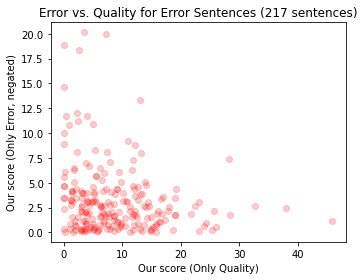

In [58]:
pts = [(score['our_score_quality'], -score['our_score_error']) for score in scores]
print(f'{(100*sum([x[1] == 0 for x in pts]) / len(pts)):.2f}% of sentences are error-less')
pts = [x for x in pts if x[1] > 0]

plt.scatter([p[0] for p in pts], [p[1] for p in pts], c ="red", alpha=0.2)
plt.xlabel('Our score (Only Quality)')
plt.ylabel('Our score (Only Error, negated)')
plt.title(f'Error vs. Quality for Error Sentences ({len(pts)} sentences)')
plt.show()

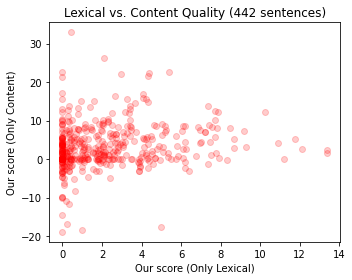

In [61]:
pts = [(score['our_score_quality_lexical'], score['our_score_quality_content']) for score in scores]
plt.scatter([p[0] for p in pts], [p[1] for p in pts], c ="red", alpha=0.2)
plt.xlabel('Our score (Only Lexical)')
plt.ylabel('Our score (Only Content)')
plt.title(f'Lexical vs. Content Quality ({len(pts)} sentences)')
plt.show()

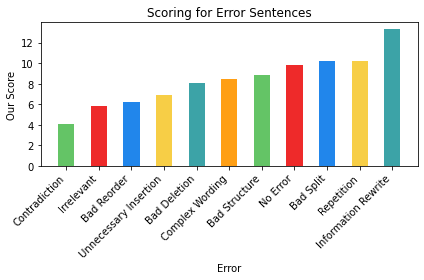

In [102]:
class Tmp(Enum):
    NO_ERROR = 'No Error'

error_segmentation = {}
for error in Error:
    error_segmentation[error] = [s for s in scores if error in s['errors']]
error_segmentation[Tmp.NO_ERROR] = [s for s in scores if len(s['errors']) == 0]

pts = []
pts += [(error, avg([s['our_score_quality'] for s in error_segmentation[error]])) for error in error_segmentation.keys()]
pts = sorted([p for p in pts if p[1] != 0], key=lambda x: x[1])

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar([p[0].value for p in pts], [p[1] for p in pts], width, color=[color_mapping[label] for label in edit_type_labels])
plt.xticks(rotation=45, ha="right")
ax.set_xlabel('Error')
ax.set_ylabel('Our Score')
ax.set_title('Scoring for Error Sentences')
plt.show()

### Edit Reversing

In [ ]:
# Problems with reversing edits:
    # Overlapping edits (of different types)
    # Deletions have no mapping to the original sentence
    # Re-orders have no mapping to their original location

In [ ]:
# My approach
    # use generate_token_dict(s) to get a list of token spans for the input/output
    # iterate through edits (in some predetermined priority order) to list the operations we perform on each word
    # perform those operations to collapse the sentence

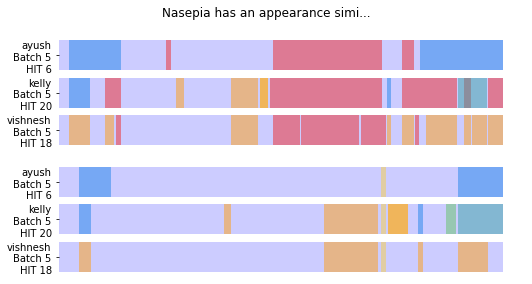

In [ ]:
from graphs import *

id_ = 40
sents = [sent for sent in data if sent['id'] == id_]
draw_agreement(sents)